In [1]:
import sys
sys.path.append('../../..')

In [ ]:
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

from rnn import RNN
from CustomDL.loops.regression import train_loop, test_loop

torch.seed(0)

# Setup

In [3]:
def run_epochs(
    epochs,
    model, loss_fn, optimizer,
    train_loader, test_loader,
    use_gpu: bool = False
) -> dict:
    loss = {
        'train': [],
        'eval': []
    }
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs}")
        train_loss = train_loop(
            model, train_loader,
            loss_fn, optimizer, True,
            use_gpu=use_gpu
        )
        loss['train'].append(sum(train_loss) / len(train_loss))
        print(f"  Average Training Loss: {loss['train'][-1]:.6f}")

        eval_loss = test_loop(
            model, test_loader, loss_fn,
            use_gpu=use_gpu
        )
        loss['eval'].append(eval_loss)
        print(f"  Average Eval Loss: {loss['eval'][-1]:.6f}")
    
    return loss

# Synthesizing Sequential Data

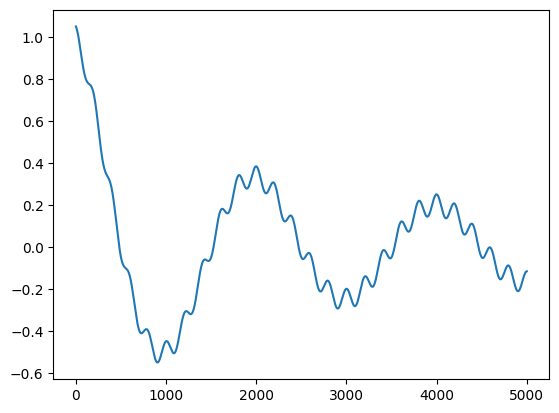

In [4]:
sampling_rate = 1000
total_secs = 5

x = torch.linspace(0, total_secs, sampling_rate * total_secs)
wave = torch.cos(torch.pi * x) / (x + 1) + 0.05 * torch.cos(2 * torch.pi * x * 5)

plt.plot(wave);

In [5]:
class WaveDataset(Dataset):
    def __init__(self,
        wave: torch.Tensor,
        lag_duration: int
    ):
        super().__init__()
        self._wave = wave.unsqueeze(1)
        self._lag_dur = lag_duration
        self._total_seq = self._wave.shape[0] - self._lag_dur
    
    def __len__(self) -> int:
        return self._total_seq
    def __getitem__(self, index):
        if index < 0:
            raise IndexError("Only support non-negative index")
        elif index > len(self):
            raise IndexError(f"Index out of range for length {len(self)}")
        return (
            self._wave[index : index + self._lag_dur],
            self._wave[index + self._lag_dur]
        )

In [6]:
dataset = WaveDataset(wave, 3)

train_idx = torch.arange(0, len(dataset) * .8, dtype=torch.int32)
test_idx = torch.arange(train_idx[-1] + 1, len(dataset))

train_set = Subset(dataset, train_idx)
test_set = Subset(dataset, test_idx)

In [7]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size, True)
test_loader = DataLoader(test_set, batch_size, True)

# Predicting the curve

Let's build a simple MLP model to predict the sequential data. Because the model be given dimensions to initialize the weights and biases, we will let the lag duration be 3. That is, the model will be given ahead three samples to predict the next sample. 

In [25]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
if torch.cuda.is_available():
    mlp_model.cuda()

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), 1e-5)

global_loss = {
    'train': [],
    'eval': []
}

In [35]:
loss = run_epochs(
    10, mlp_model, mse_loss,
    optimizer, train_loader, test_loader,
    torch.cuda.is_available()
)

global_loss['train'].extend(loss['train'])
global_loss['eval'].extend(loss['eval'])

1/10


100%|██████████| 125/125 [00:00<00:00, 167.17it/s, loss=6.873883830849081e-05] 


  Average Training Loss: 0.000098
  Average Eval Loss: 0.000079
2/10


100%|██████████| 125/125 [00:00<00:00, 190.39it/s, loss=7.602059486089274e-05] 


  Average Training Loss: 0.000089
  Average Eval Loss: 0.000071
3/10


100%|██████████| 125/125 [00:00<00:00, 182.55it/s, loss=5.4419509979197755e-05]


  Average Training Loss: 0.000080
  Average Eval Loss: 0.000062
4/10


100%|██████████| 125/125 [00:00<00:00, 176.68it/s, loss=6.964463682379574e-05] 


  Average Training Loss: 0.000073
  Average Eval Loss: 0.000055
5/10


100%|██████████| 125/125 [00:00<00:00, 156.42it/s, loss=7.227209425764158e-05] 


  Average Training Loss: 0.000066
  Average Eval Loss: 0.000049
6/10


100%|██████████| 125/125 [00:00<00:00, 179.11it/s, loss=4.467615144676529e-05] 


  Average Training Loss: 0.000060
  Average Eval Loss: 0.000045
7/10


100%|██████████| 125/125 [00:00<00:00, 189.73it/s, loss=3.5780725738732144e-05]


  Average Training Loss: 0.000055
  Average Eval Loss: 0.000038
8/10


100%|██████████| 125/125 [00:00<00:00, 195.61it/s, loss=5.0156013458035886e-05]


  Average Training Loss: 0.000050
  Average Eval Loss: 0.000035
9/10


100%|██████████| 125/125 [00:00<00:00, 192.07it/s, loss=7.224344881251454e-05] 


  Average Training Loss: 0.000046
  Average Eval Loss: 0.000031
10/10


100%|██████████| 125/125 [00:00<00:00, 180.96it/s, loss=4.4242493459023535e-05]


  Average Training Loss: 0.000042
  Average Eval Loss: 0.000027


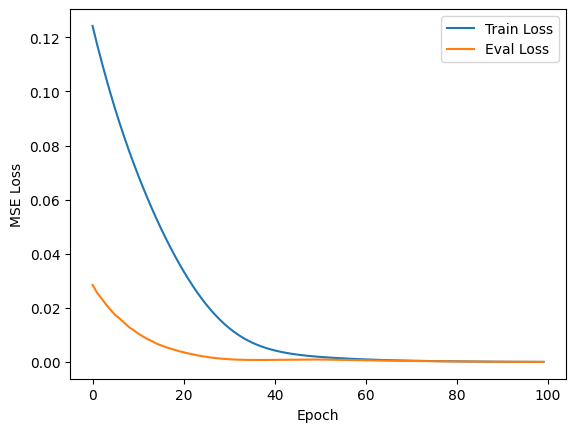

In [36]:
plt.plot(global_loss['train'], label='Train Loss')
plt.plot(global_loss['eval'], label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend();

In [ ]:
checkpoint = {
    'model': mlp_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss': global_loss
}

torch.save(checkpoint, '../output/mlp_wave.tar')

# The Recurrent Network

In [18]:
model = RNN(1, 5)